# Discriminator Tutorial

In [7]:
from qiskit_experiments.measurement.discriminator import Discriminator
from qiskit_experiments.composite import ParallelExperiment
from qiskit.providers.backend import BackendV1 as Backend
from typing import Tuple
from qiskit.providers.options import Options
from qiskit.qobj.utils import MeasLevel

from qiskit import QuantumCircuit
from qiskit_experiments.test.mock_iq_backend import MockIQBackend

from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.nodes import Probability, Discriminate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class DiscriminatorBackend(MockIQBackend):
    """
    A simple backend that generates gaussian data for discriminator tests
    """

    def __init__(
        self,
        iq_cluster_centers: Tuple[float, float, float, float] = (1.0, 1.0, -1.0, -1.0),
        iq_cluster_width: float = 1.5,
    ):
        """
        Initialize the discriminator backend
        """
        super().__init__(iq_cluster_centers, iq_cluster_width)
        self.configuration().basis_gates = ["x"]

    def _compute_probability(self, circuit: QuantumCircuit) -> float:
        """Returns the probability based on the frequency."""
        if circuit.data[0][0].name == "x":
            return 1
        elif circuit.data[0][0].name == "barrier":
            return 0

## Run Example Discriminator Experiment on One Qubit

---------------------------------------------------
Experiment: Discriminator
Experiment ID: 32238271-0ad0-41ab-93f0-cc08371e01ae
Status: DONE
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- discriminator: LinearDiscriminantAnalysis()
- coef: [[1.9810308  2.27199354]]
- intercept: [0.43088017]
- score: 1.0
- success: True


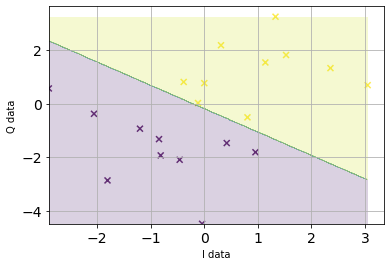

In [25]:
backend = DiscriminatorBackend()
exp = Discriminator(1)
exp.set_analysis_options(discriminator_type="LDA")
exp.set_run_options(meas_level=MeasLevel.KERNELED)
lda_res = exp.run(backend, shots=10)

print(lda_res)

---------------------------------------------------
Experiment: Discriminator
Experiment ID: 3bd26d72-d6fb-471f-8a1d-33d4ed86bceb
Status: DONE
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- discriminator: QuadraticDiscriminantAnalysis()
- rotations: [array([[-0.43811802,  0.89891746],
       [-0.89891746, -0.43811802]]), array([[-0.17039714,  0.98537547],
       [ 0.98537547,  0.17039714]])]
- score: 0.825
- success: True


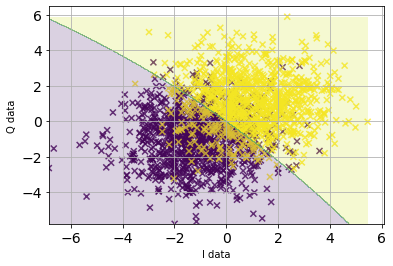

In [26]:
backend = DiscriminatorBackend()
exp = Discriminator(1)
exp.set_analysis_options(discriminator_type="QDA")
exp.set_run_options(meas_level=MeasLevel.KERNELED)
qda_res = exp.run(backend, shots=1000)

print(qda_res)

## Run Discriminator Experiments in Parallel 

Multiple discriminators can be calibrated and analyzed at the same time using the parallel experiments framework. Note that the measurement level of the ParallelExperiment needs to be set to kerneled.

In [237]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

IBMQ.load_account()
provider = IBMQ.get_provider(
    hub="ibm-q-internal", group="dev-sys-software", project="internal-test"
)
# backend = least_busy(provider.backends())

ibmqfactory.load_account:WARNING:2021-07-18 10:49:31,704: Credentials are already in use. The existing account in the session will be replaced.


We can use the `ParallelExperiment` framework to take discriminator calibration data over multiple qubits simultaneously. It's important that `MeasLevel` is set to kerneled and `meas_return` is set to single so that the data points returned are individual undiscriminated shots.

---------------------------------------------------
Experiment: ParallelExperiment
Experiment ID: 71422bc8-7a59-43f4-b81e-17f1f06c25db
Status: DONE
Component Experiments: 2
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- experiment_types: ['Discriminator', 'Discriminator']
- experiment_ids: ['6b6aac19-5995-45af-9149-96ad8cf44633', 'cfbfc3d6-bd9e-41f8-92b4-1e5e93787c85']
- experiment_qubits: [(0,), (1,)]
- success: True


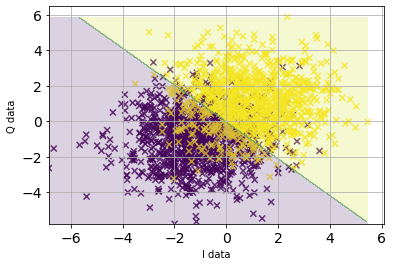

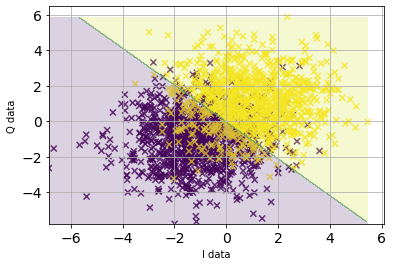

In [36]:
from qiskit_experiments.measurement.discriminator import Discriminator, DiscriminatorAnalysis
from qiskit_experiments.composite import ParallelExperiment

backend = DiscriminatorBackend()
par_exp = ParallelExperiment([Discriminator(0), Discriminator(1)])
par_exp.set_run_options(meas_level=MeasLevel.KERNELED, meas_return="single")
par_expdata = par_exp.run(backend, shots=1000)
print(par_expdata)

## Use Data Processor Discriminator Node

---------------------------------------------------
Experiment: Discriminator
Experiment ID: 09df986a-26ed-45ea-bf22-65accf02ab8c
Status: DONE
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- discriminator: QuadraticDiscriminantAnalysis()
- rotations: [array([[-0.43811802,  0.89891746],
       [-0.89891746, -0.43811802]]), array([[-0.17039714,  0.98537547],
       [ 0.98537547,  0.17039714]])]
- score: 0.825
- success: True


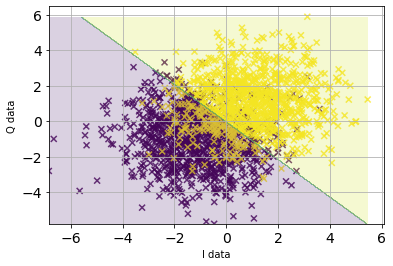

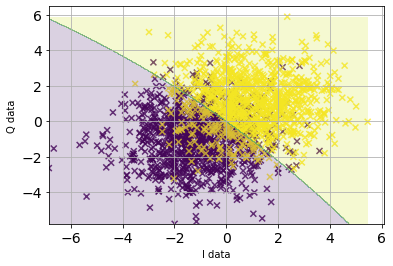

In [30]:
backend = DiscriminatorBackend()
exp = Discriminator(1)
exp.set_analysis_options(discriminator_type="LDA")
exp.set_run_options(meas_level=MeasLevel.KERNELED)
lda_res = exp.run(backend, shots=1024)
processor = DataProcessor("memory", [Discriminate(lda_res)])
processor.append(Probability("0"))
datum = processor(lda_res.data(0))

backend = DiscriminatorBackend()
exp2 = Discriminator(1)
exp2.set_analysis_options(discriminator_type="QDA")
exp2.set_run_options(meas_level=MeasLevel.KERNELED)
qda_res = exp2.run(backend, shots=1000)
qda_processor = DataProcessor("memory", [Discriminate(qda_res)])
qda_processor.append(Probability("0"))
print(qda_res)
datum = qda_processor(qda_res.data(0))

In [33]:
# LDA node
processor = DataProcessor("memory", [Discriminate(lda_res)])
processor.append(Probability("0"))
datum = processor(lda_res.data(0))
print(datum)

# QDA node
processor = DataProcessor("memory", [Discriminate(qda_res)])
processor.append(Probability("0"))
datum = processor(qda_res.data(0))

print(datum)

(0.8447265625, 0.011317660990670282)
(0.819, 0.012175343937647102)


Using a parallel experiment to discriminate over multiple qubits:

In [37]:
processor = DataProcessor("memory", [Discriminate(par_expdata)])
processor.append(Probability("01"))

datum = processor([par_expdata.data(0), par_expdata.data(1)])
print(datum)

(0.682, 0.014726710426975875)
